In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL.Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

from IPython.display import Image, display

In [10]:
model_builder = tf.keras.applications.mobilenet_v2.MobileNetV2
img_size = (224, 224)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Last conv layer name of mobilenet_v2
last_conv_layer_name = "Conv_1_bn"

img_path = "fireboat.png"
img_index = 554

In [11]:
def preprocess_image(img_path, size=img_size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img) # convert to numpy array of shape (height, width, channels)
    array = np.expand_dims(array, axis=0) # add batch dimension, shape becomes (1, height, width, channels)
    return array

In [12]:
def make_gradCam_heatmap(processed_img, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, pred = grad_model(processed_img)
        if pred_index is None:
            pred_index = tf.argmax(pred[0])
        yc = pred[:, pred_index]
    
    grad_map = tape.gradient(yc, conv_outputs)

    pooled_grad = tf.reduce_mean(grad_map, axis=(0,1,2))

    conv_outputs = conv_outputs[0]   #since the batch size = 1
    
    heatmap = conv_outputs @ pooled_grad[..., tf.newaxis]       # @ matrix multiplication

    heatmap = tf.squeeze(heatmap)  # remove the newaxis (dummy)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)      # Relu opt.

    return heatmap.numpy()
    

In [13]:
def save_and_display_gradCam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):

    # Load image from img_path
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap
    heatmap = np.uint8(heatmap*255)

    # convert to RGB using jet color-map
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Process image
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimposed the heatmap on original img
    superimpoed_img = jet_heatmap * alpha + img
    superimpoed_img = tf.keras.utils.array_to_img(superimpoed_img)
    superimpoed_img.save(cam_path)

    # Display gradCam
    # display(Image(cam_path))
    return superimpoed_img


/home/sanjoy-kumar/.local/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_156']. Received: the structure of inputs=*
  warnings.warn(


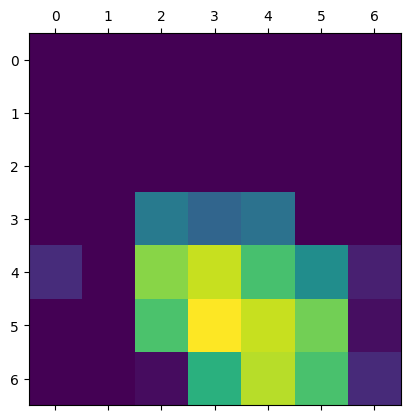

In [14]:
processed_image = preprocess_input(preprocess_image(img_path))
model = model_builder(weights="imagenet")

# Remove softmax activation layer
# model.layers[-1].activation = None

heatmap = make_gradCam_heatmap(processed_image, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
prediction:  [[('n03344393', 'fireboat', np.float32(0.39148834))]]


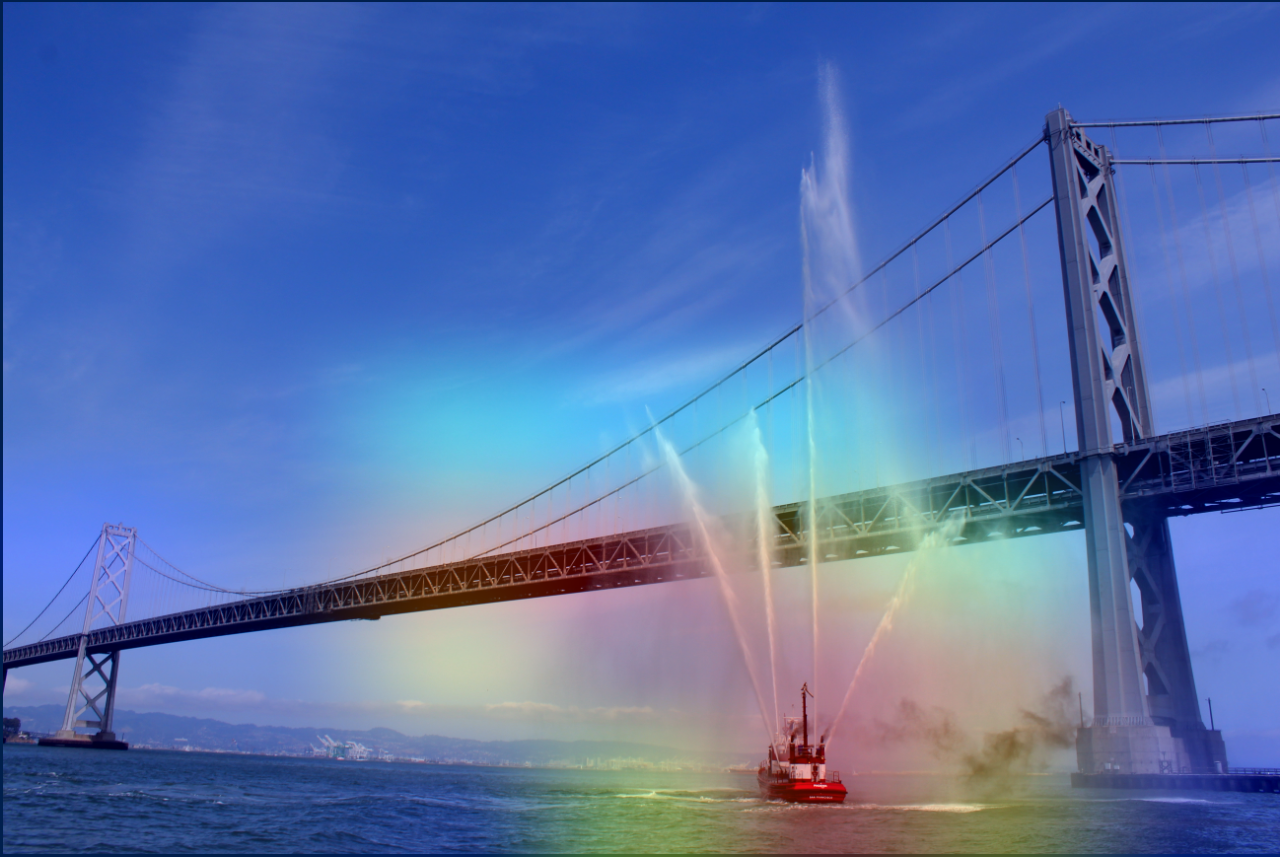

In [15]:
preds = model.predict(processed_image)
print("prediction: ", decode_predictions(preds, top=1))

save_and_display_gradCam(img_path, heatmap)